In [2]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import random
import torch
import copy
from torch.distributions.bernoulli import Bernoulli
import pandas as pd
from scipy import stats

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.optim.Actor import Actor
from gsnn.optim.Actor import EmbeddedActor
from gsnn.optim.Actor import GSNNActor
from gsnn.optim.Environment import Environment
from gsnn.optim.SurrogateEnvironment import SurrogateEnvironment
from gsnn.optim.ExperienceRecord import ExperienceRecord

from gsnn.optim.RewardScaler import RewardScaler
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc           # required to unpickle data 
from gsnn.optim.Node2Vec import Node2Vec
from gsnn.optim.DGI import DGI
from gsnn.optim.PPO import PPO

from sklearn.metrics import roc_auc_score

from gsnn.optim.BayesOpt import BayesOpt

import argparse

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Using bayesian optimization to learn optimal selection of prior knowledge 

In many cases, prior knowledge is incomplete, noisy or spurrious for specific prediction tasks. In this example, we will demonstrate how we can use the reinforcement learning for the optimal selection of prior knowledge. 

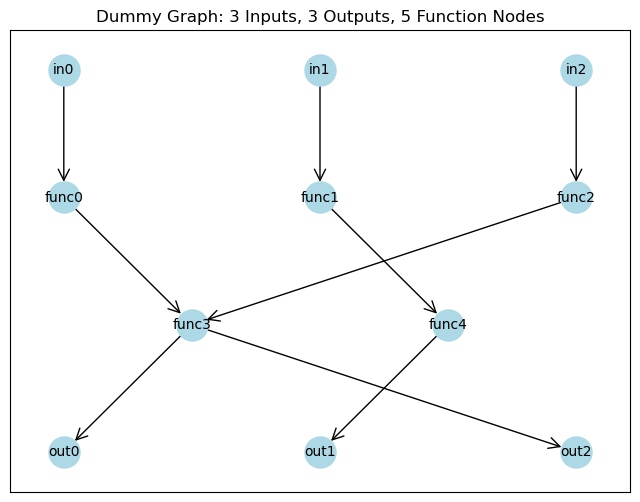

In [3]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [4]:
#special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
#                     'func0': lambda x: np.mean(([(xx-1)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}
special_functions = None

x_train, x_test, y_train, y_test = simulate(G, n_train=100, n_test=1000, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions, noise_scale=1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)

y_train = (y_train - y_mu)/(y_std + 1e-8)
y_test = (y_test - y_mu)/(y_std + 1e-8)



In [5]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# add some false edges 
edge_index_dict = copy.deepcopy(data.edge_index_dict)
edge_index_dict['function', 'to', 'function']  = torch.cat((edge_index_dict['function', 'to', 'function'], torch.tensor([[0, 1, 1, 2],
                                                                                                                         [1, 0, 2, 1]], dtype=torch.long)), dim=-1)

In [9]:
data.edge_index_dict = edge_index_dict

args = argparse.Namespace()

# GSNN model parameters (model+graph we are evaluating performance of)
args.channels = 10
args.layers = 4
args.dropout = 0
args.share_layers = False 
args.add_function_self_edges = True
args.norm = 'none'

# GSNN training parameters 
args.lr = 1e-2
args.max_epochs = 50
args.patience = 5
args.min_delta = 1e-2
args.batch = 100
args.workers = 3

# Surrogate GSNN model parameters 
# trained to predict GSNN performance based on graph selection
args.surr_channels = 25
args.surr_norm = 'layer'
args.surr_layers = 4
args.surr_dropout = 0
args.surr_bias = False
args.surr_share_layers = False

# Surrogate GSNN training params
args.surr_batch = 25
args.surr_lr = 1e-2
args.surr_wd = 0
args.surr_epochs = 250
args.surr_patience = 10

# candidate selection via REINFORCE parameters
args.rl_batch = 25
args.rl_samples = 50
args.rl_iters = 50

# Surrogate GSNN hypernetwork parameters (responsible for uncertainty in prediction)
args.stochastic_channels = 8
args.hnet_width = 20
args.samples = 100

# bayesian optimization parameters
args.bayesopt_batch_size = 2
args.record_dir = '05_bayesopt_tmp'
args.metric = 'spearman' # reward metric 
args.reward_agg = 'auc' # [last, best, auc]

In [10]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train, torch.arange(x_train.size(0)))
test_dataset = torch.utils.data.TensorDataset(x_test, y_test, torch.arange(x_test.size(0)))

bayesopt = BayesOpt(args, data, train_dataset, test_dataset)

50 experiences loaded.


In [13]:
bayesopt.warmup(0)

KeyboardInterrupt: 

selecting candidates... 9/10 || mean obj (mean): -0.893 || loss: 0.0833
[mean] true graph rank: 3
[mean] acc-rank correlation -0.6663184725384765
selecting candidates... 9/10 || mean obj (EI): 0.150 || loss: -0.0536
[EI] true graph rank: 85
[EI] acc-rank correlation 0.24583066238726087
selecting candidates... 9/10 || mean obj (UCB): 0.561 || loss: -0.0089
[UCB] true graph rank: 12
[UCB] acc-rank correlation -0.13250135635545562
selecting candidates... 9/10 || mean obj (LCB): -3.278 || loss: 0.0598
[LCB] true graph rank: 1
[LCB] acc-rank correlation -0.6881070548940726
selecting candidates... 9/10 || mean obj (PI): 0.004 || loss: 0.0279
[PI] true graph rank: 3
[PI] acc-rank correlation -0.3456285227984644


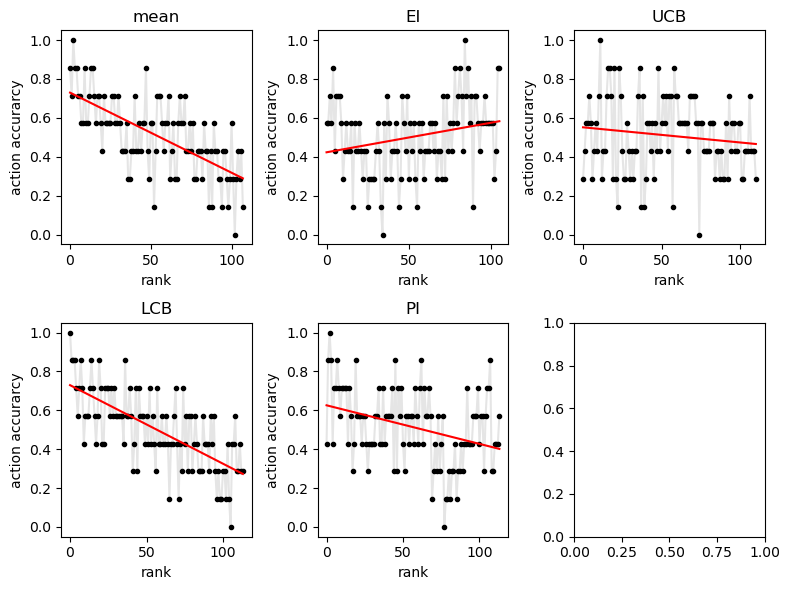

In [14]:
f,axes = plt.subplots(2,3, figsize=(8,6))

for i,obj in enumerate(['mean', 'EI', 'UCB', 'LCB', 'PI']): 
    top_cand, top_obj = bayesopt.get_candidates(N=None, objective=obj, samples=50, k=10, iters=10)
    cand_acc = ((top_cand.detach().cpu().numpy() == np.array([1]*3 + [0]*4).reshape(1,-1)).astype(float)).mean(-1)

    xx = np.linspace(-1,1, len(cand_acc))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=xx, y=cand_acc)
    regression_line = slope * xx + intercept

    print(f'[{obj}] true graph rank:', np.where(cand_acc==1)[0][0] + 1)
    print(f'[{obj}] acc-rank correlation', np.corrcoef(xx, cand_acc)[0,1])

    axes.flat[i].set_title(obj)
    axes.flat[i].plot(cand_acc, 'k.')
    axes.flat[i].plot(cand_acc, 'k-', alpha=0.1)
    axes.flat[i].plot(regression_line, 'r-', label='')
    axes.flat[i].set_xlabel('rank')
    axes.flat[i].set_ylabel('action accurarcy')

plt.tight_layout()
plt.show()

In [12]:
# TODO: should we decay exploration (e.g., q) during training so we end with high exploitation
best_reward_per_iter = bayesopt.run(iters=20, objective='UCB', obj_kwargs={'q':0.6}, neighborhood_size=5)

selecting candidates... 49/50 || mean obj (UCB): 0.835 || loss: 0.00944
	--> evaluating candidate actions... [progress: 2/2]
0 experiences loaded.


KeyboardInterrupt: 

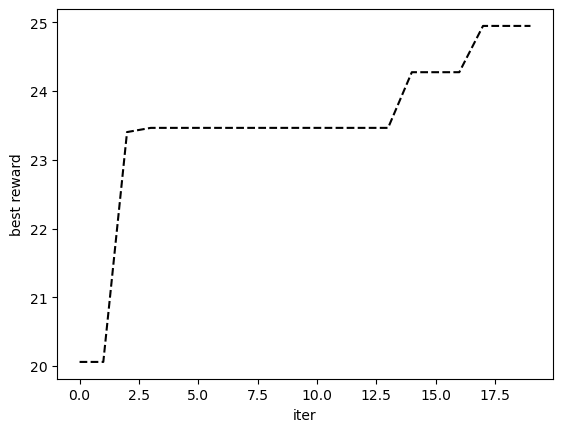

In [13]:
plt.figure()
plt.plot(best_reward_per_iter, 'k--') 
plt.xlabel('iter')
plt.ylabel('best reward')
plt.show()

selecting candidates... 9/10 || mean obj (mean): 0.726 || loss: 0.0808
[mean] true graph rank: 12
[mean] acc-rank correlation -0.5113746215009908
selecting candidates... 9/10 || mean obj (EI): 0.288 || loss: 0.00569
[EI] true graph rank: 48
[EI] acc-rank correlation -0.4652487246266717
selecting candidates... 9/10 || mean obj (UCB): 1.246 || loss: 0.04185
[UCB] true graph rank: 11
[UCB] acc-rank correlation -0.6127921011036166
selecting candidates... 9/10 || mean obj (LCB): -0.164 || loss: 0.00464
[LCB] true graph rank: 1
[LCB] acc-rank correlation -0.3113321666335384
selecting candidates... 9/10 || mean obj (PI): 0.006 || loss: 0.0256
[PI] true graph rank: 2
[PI] acc-rank correlation -0.41346587580114114


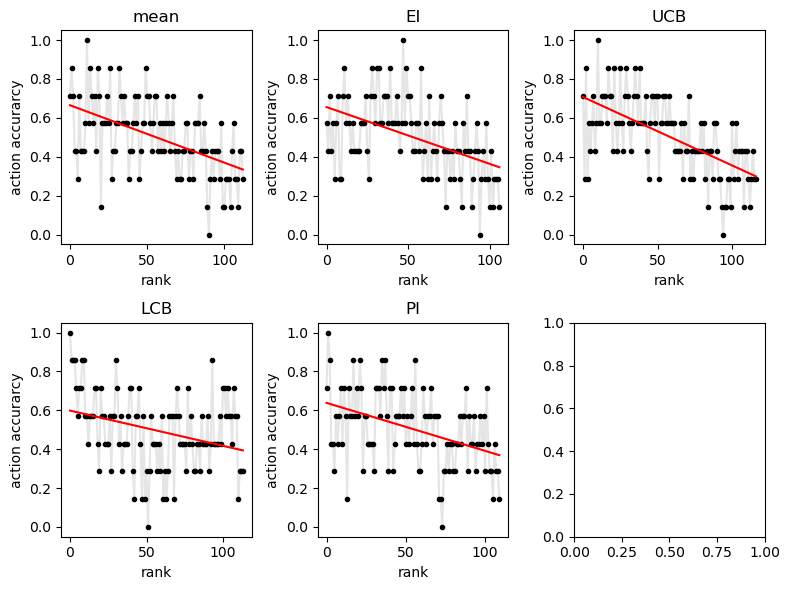

In [14]:
f,axes = plt.subplots(2,3, figsize=(8,6))

for i,obj in enumerate(['mean', 'EI', 'UCB', 'LCB', 'PI']): 
    top_cand, top_obj = bayesopt.get_candidates(N=None, objective=obj, samples=50, k=10, iters=10)
    cand_acc = ((top_cand.detach().cpu().numpy() == np.array([1]*3 + [0]*4).reshape(1,-1)).astype(float)).mean(-1)

    xx = np.linspace(-1,1, len(cand_acc))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x=xx, y=cand_acc)
    regression_line = slope * xx + intercept

    print(f'[{obj}] true graph rank:', np.where(cand_acc==1)[0][0] + 1)
    print(f'[{obj}] acc-rank correlation', np.corrcoef(xx, cand_acc)[0,1])

    axes.flat[i].set_title(obj)
    axes.flat[i].plot(cand_acc, 'k.')
    axes.flat[i].plot(cand_acc, 'k-', alpha=0.1)
    axes.flat[i].plot(regression_line, 'r-', label='')
    axes.flat[i].set_xlabel('rank')
    axes.flat[i].set_ylabel('action accurarcy')

plt.tight_layout()
plt.show()

best avg reward 24.948032307064082
best action tensor([1., 1., 1., 1., 0., 0., 0.])
best action edge accuracy 0.8571428571428571


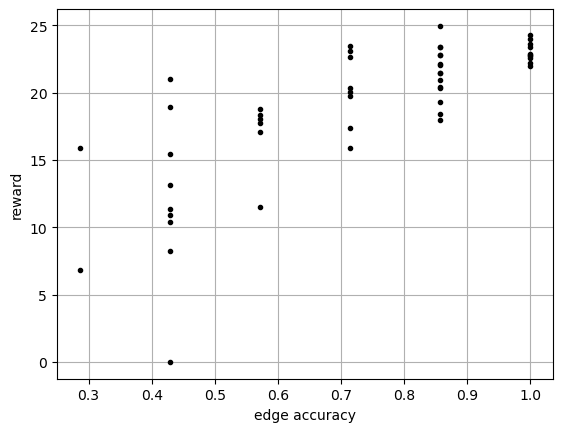

In [16]:
best_reward_idx = np.stack([np.array(r) for r in bayesopt.record.rewards], axis=0).mean(axis=(-1)).argmax()
best_reward = bayesopt.record.rewards[best_reward_idx].mean()
best_action = bayesopt.record.actions[best_reward_idx]
best_action_acc = ((best_action.detach().cpu().numpy() == np.array([1]*3 + [0]*4).reshape(-1)).astype(float)).mean(-1)
print('best avg reward', best_reward)
print('best action', best_action)
print('best action edge accuracy', best_action_acc)

rewards = np.stack(bayesopt.record.rewards).mean(-1)
acc = ((bayesopt.record.actions == np.array([1]*3 + [0]*4).reshape(1,-1)).astype(float)).mean(-1)

plt.figure()
plt.plot(acc, rewards, 'k.')
plt.xlabel('edge accuracy')
plt.ylabel('reward')
plt.grid()
plt.show()

In [14]:
# number of possible subgraphs given 7 edges: 
# 2^7 = 128
# altho, an environment run is deterministic and therefore may result in "noisy" rewards